In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

plt.style.use('dark_background')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import math

def entropy( x, b ):
    s = 0
    for p in x:
        if p > 0:
            s += -p*math.log(p,b)
        # end
    # end
    return s
# end

def visualize_regions(model, MAX, nGrid):
    a1 = np.linspace(-MAX, MAX, nGrid)
    a2 = np.linspace(-MAX, MAX, nGrid)

    A1, A2 = np.meshgrid(a1, a2)
    A1 = A1.flatten()
    A2 = A2.flatten()
    A = np.vstack((A1, A2)).T

    # Predict B
    B = model.predict(A)
    B = B.reshape(nGrid, nGrid)
    B = np.flipud(B)

    # Compute entropy for S
    prob_2D = model.predict_proba(A)
    S = np.array([entropy(p, 2) for p in prob_2D])
    S = S.reshape(nGrid, nGrid)
    S = np.flipud(S)

    return B, S
# end

def visualize_regions_keras(model, MAX, nGrid):
    a1 = np.linspace(-MAX, MAX, nGrid)
    a2 = np.linspace(-MAX, MAX, nGrid)

    A1, A2 = np.meshgrid(a1, a2)
    A1 = A1.flatten()
    A2 = A2.flatten()
    A = np.vstack((A1, A2)).T

    # Predict B
    B = model.predict(A).argmax(axis=1)
    B = B.reshape(nGrid, nGrid)
    B = np.flipud(B)

    # Compute entropy for S
    #prob_2D = model.predict_proba(A)
    prob_2D = model.predict(A)
    S = np.array([entropy(p, 2) for p in prob_2D])
    S = S.reshape(nGrid, nGrid)
    S = np.flipud(S)

    return B, S
# end

## Create data

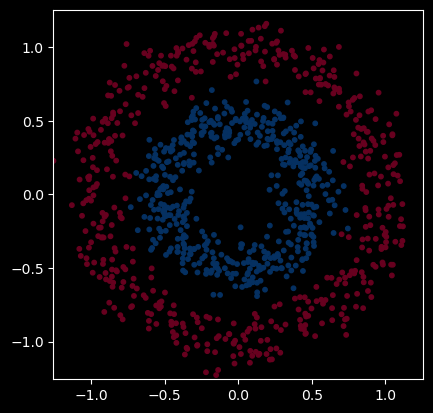

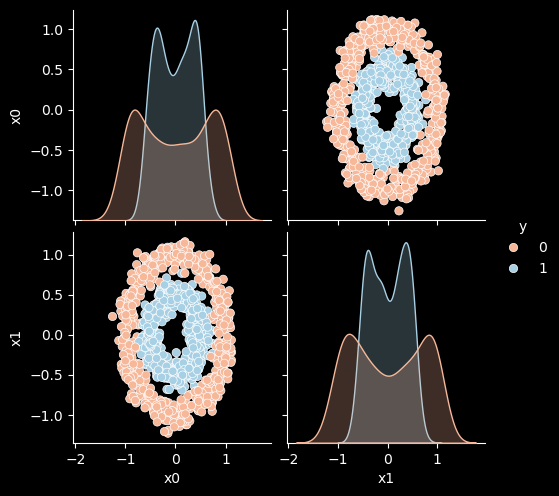

In [22]:
from sklearn.datasets import make_classification, make_blobs, make_moons, make_circles

n_samples = 1000

choice = 3

if   choice == 0:
    X, y = make_blobs(
        n_samples=n_samples,
        n_features=2,
        centers=2,
        cluster_std=5,
        random_state=10
    )
elif choice == 1:
    X, y = make_classification(
        n_samples=n_samples,
        n_features=2,
        n_informative=2,
        n_redundant=0,
        n_clusters_per_class=1,
        n_classes=3,
        random_state=41
    )
elif choice == 2:
    X, y = make_moons(
        n_samples=n_samples,
        noise=0.2,
        random_state=42
    )
elif choice == 3:
    X, y = make_circles(
        n_samples=n_samples,
        noise=0.1,
        factor=0.5,
        random_state=42
    )
# end

X = X - X.mean(axis=0)

MAX = np.max(np.abs(X))

plt.style.use('dark_background')

plt.scatter(X[:,0], X[:,1], c=y, s=10, cmap="RdBu");
plt.xlim(-MAX,MAX)
plt.ylim(-MAX,MAX)
plt.gca().set_aspect('equal')
plt.show()

df = pd.DataFrame( {"x0":X[:,0], "x1":X[:,1], "y":y} )
sns.pairplot(df, hue='y', palette='RdBu')
plt.show()

## Modeling

## Train/test split

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y
)

## Keras

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

dropout_rate = 0.1

n_classes = np.unique(y).shape[0]

# Create model
model = Sequential([
    Input(shape=X.shape[1:]),
    
    Dense(10, activation='relu'),
    #BatchNormalization(),
    Dropout(dropout_rate),
    
    Dense(10, activation='relu'),
    #BatchNormalization(),
    Dropout(dropout_rate),
    
    Dense(10, activation='relu'),
    
    Dense(n_classes, activation='softmax'),
])

# Define the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.01)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=100,          # Stop after 5 epochs without improvement
    restore_best_weights=True  # Restore the best weights after stopping
)

# Display model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                     │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52 (208.00 B)

 Trainable params: 52 (208.00 B)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Train model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5387 - loss: 0.7211 - val_accuracy: 0.5000 - val_loss: 0.6922
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4919 - loss: 0.6809 - val_accuracy: 0.5150 - val_loss: 0.6637
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5519 - loss: 0.6533 - val_accuracy: 0.6650 - val_loss: 0.6340
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7089 - loss: 0.6166 - val_accuracy: 0.7350 - val_loss: 0.6000
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7717 - loss: 0.5858 - val_accuracy: 0.8200 - val_loss: 0.5588
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7921 - loss: 0.5480 - val_accuracy: 0.9350 - val_loss: 0.5070
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8782 - loss: 0.4807 - val_accuracy: 0.9500 - val_loss: 0.4436
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8900 - loss: 0.4337 - val_accuracy: 0.9750 - 

In [31]:
# predict gives class probabilities
model.predict(X_train)[:5,:]

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step


array([[1.1297174e-02, 9.8870289e-01],
       [9.8729008e-01, 1.2709957e-02],
       [9.7150067e-03, 9.9028498e-01],
       [9.9999273e-01, 7.2522448e-06],
       [1.1853541e-02, 9.8814654e-01]], dtype=float32)

In [32]:
# use argmax to get class labels
y_test_prob = model.predict(X_test)
y_test_pred = y_test_prob.argmax(axis=1)
y_test_pred[:5]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


array([0, 1, 1, 0, 0], dtype=int64)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


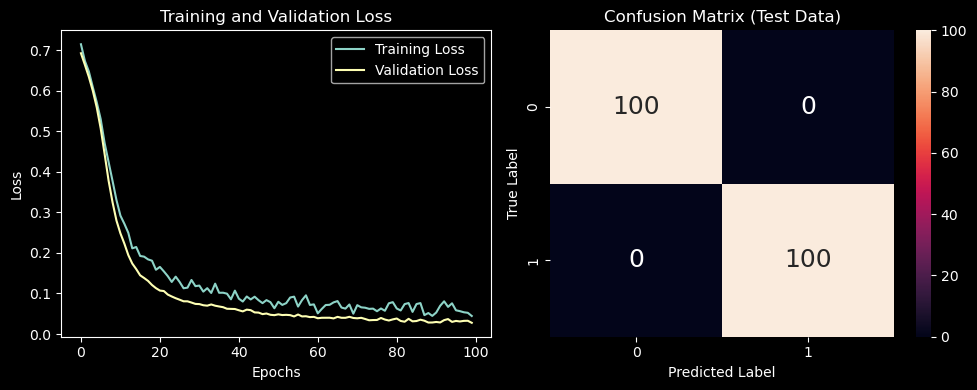

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 468us/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 463us/step


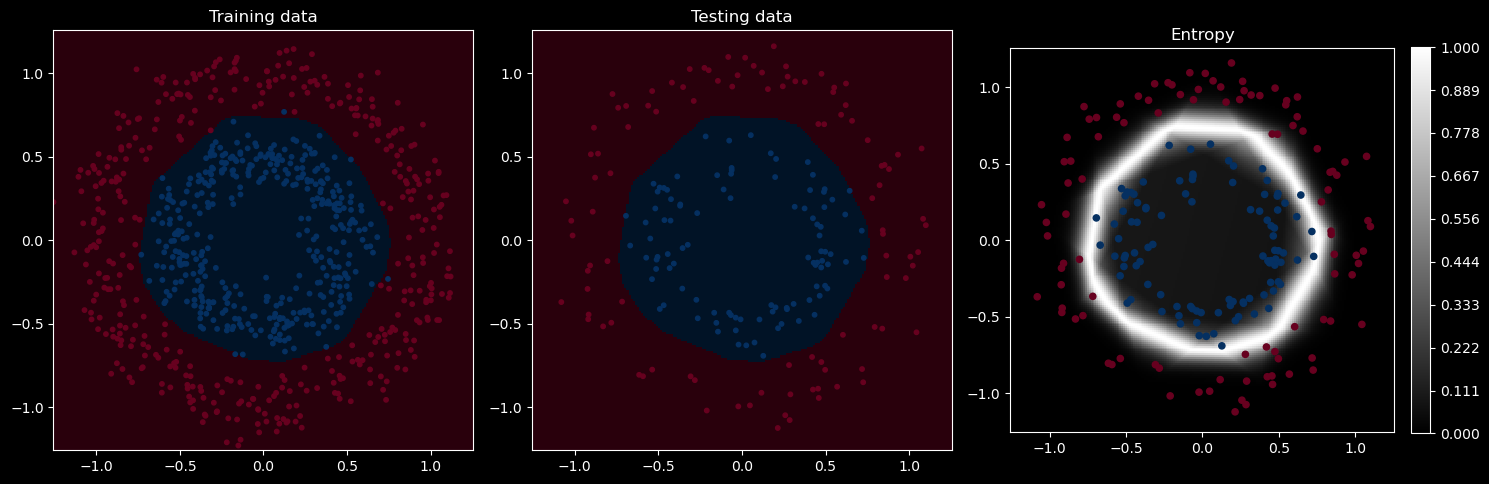

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [33]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get predictions
y_train_pred = model.predict(X_train).argmax(axis=1)
y_test_pred  = model.predict(X_test).argmax(axis=1)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left subplot: Training and Validation Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
#axes[0].set_yscale('log')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Right subplot: Confusion Matrix (Test Data) using seaborn heatmap with vmin set to 0
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[1], vmin=0, 
            annot_kws={"size": 18})
axes[1].set_title('Confusion Matrix (Test Data)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

# get decision boundaries and regions
B, S = visualize_regions_keras(model, MAX, 200)
    
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

extent = [-MAX,MAX,-MAX,MAX]
cmap = "RdBu"

# left subplot: regions + training set
axes[0].imshow(B, interpolation='none', extent=extent,cmap=cmap, alpha=0.4)
axes[0].scatter(X_train[:,0], X_train[:,1], c=y_train, s=10, cmap=cmap);
axes[0].set_aspect('equal')
axes[0].set_title('Training data');

# left subplot: regions + test set
axes[1].imshow(B, interpolation='none', extent=extent,cmap=cmap, alpha=0.4)
axes[1].scatter(X_test[:,0], X_test[:,1], c=y_test, s=10, cmap=cmap);
axes[1].set_aspect('equal')
axes[1].set_title('Testing data');

# entropy of regions
im = axes[2].imshow(S, interpolation='none', extent=extent,cmap='gray')
axes[2].scatter(X_test[:,0], X_test[:,1], c=y_test, s=20, cmap=cmap);
axes[2].set_aspect('equal')
axes[2].set_title('Entropy')
cbar = fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
cbar.set_ticks(np.linspace(0, math.log(y.max()+1,2), 10))

plt.tight_layout()
plt.show()

# Print classification report for test data
report = classification_report(y_test, y_test_pred)
print(report)

# Compare w/ other models

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

models = [
    LogisticRegression(),
    KNeighborsClassifier(n_neighbors=1,   weights='uniform'),
    KNeighborsClassifier(n_neighbors=10,  weights='uniform'),
    KNeighborsClassifier(n_neighbors=50,  weights='uniform'),
    RandomForestClassifier(n_estimators=10,  max_leaf_nodes=10),
    RandomForestClassifier(n_estimators=100, max_leaf_nodes=3),
    RandomForestClassifier(n_estimators=100, max_leaf_nodes=10),
    GradientBoostingClassifier(n_estimators=10,  learning_rate=0.1, max_leaf_nodes=3),
    GradientBoostingClassifier(n_estimators=10,  learning_rate=0.1, max_leaf_nodes=10),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_leaf_nodes=3),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_leaf_nodes=10),
]

LogisticRegression()


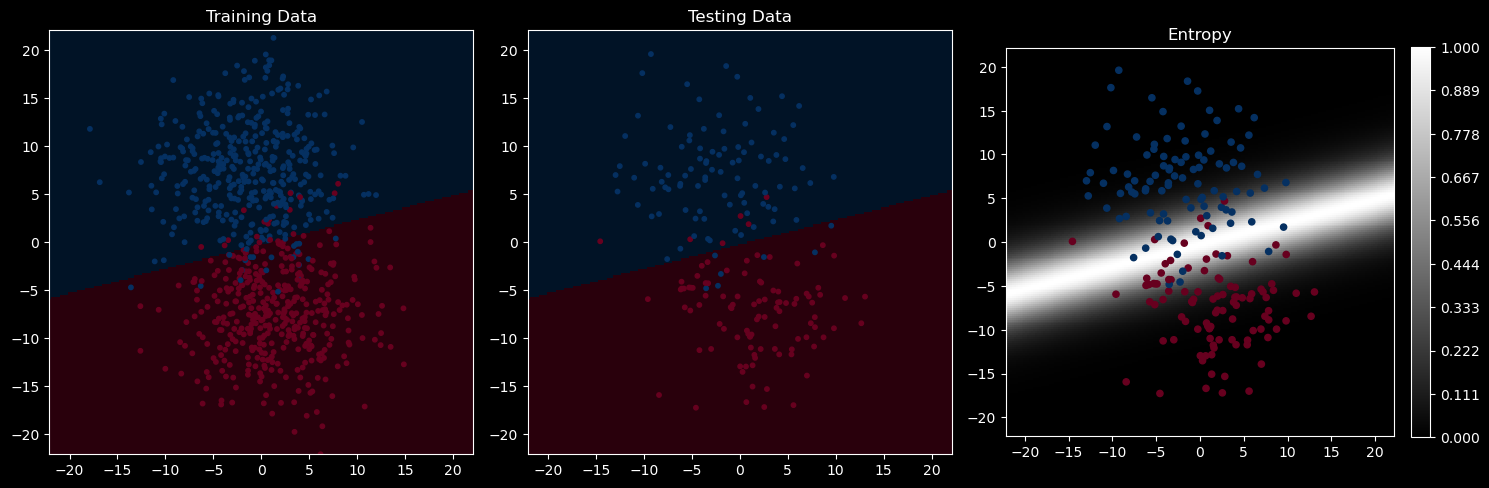

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       100
           1       0.94      0.93      0.93       100

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.93       200
weighted avg       0.94      0.94      0.93       200



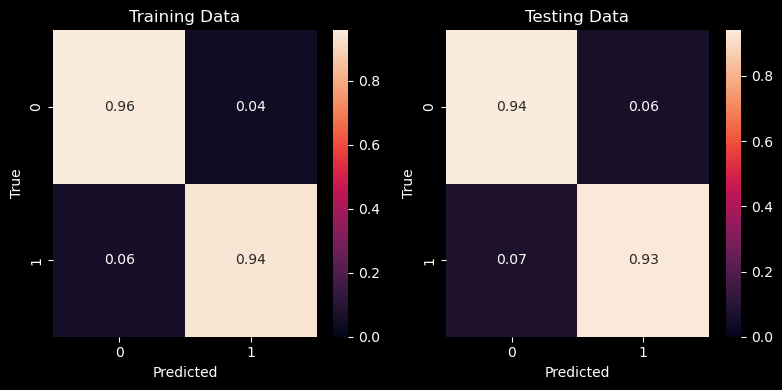

KNeighborsClassifier(n_neighbors=1)


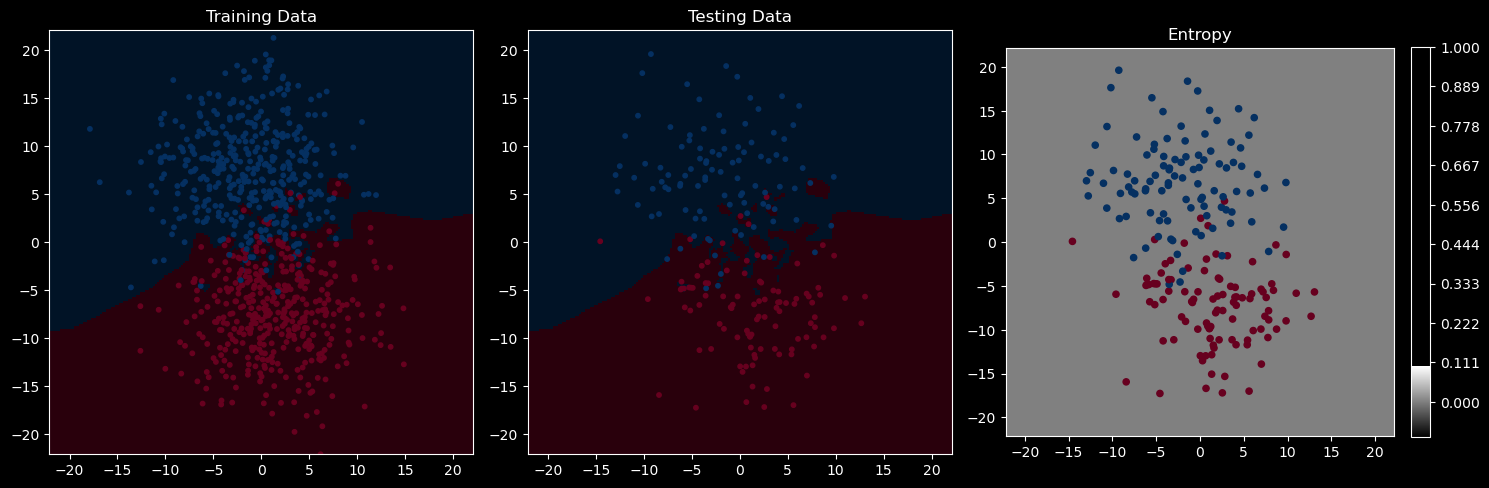

              precision    recall  f1-score   support

           0       0.87      0.90      0.89       100
           1       0.90      0.87      0.88       100

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.88       200
weighted avg       0.89      0.89      0.88       200



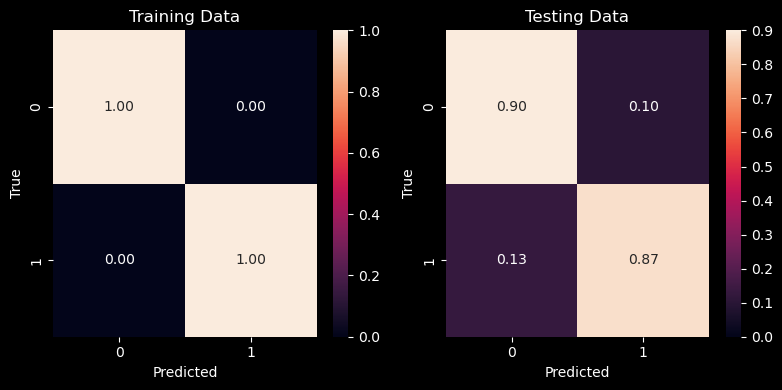

KNeighborsClassifier(n_neighbors=10)


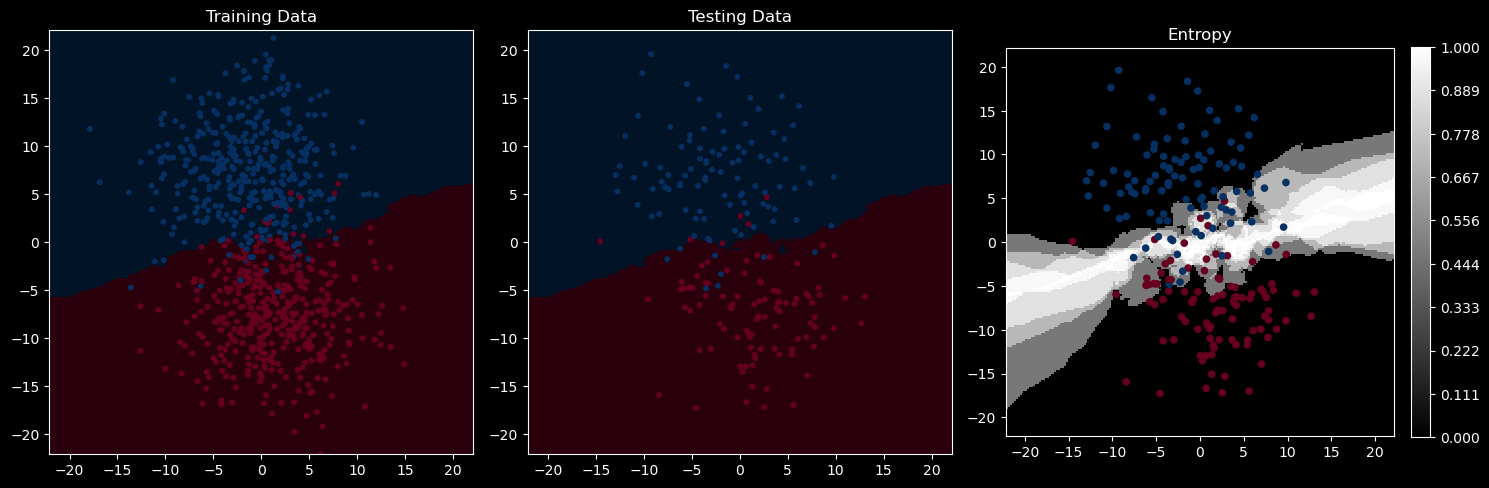

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       100
           1       0.94      0.92      0.93       100

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200



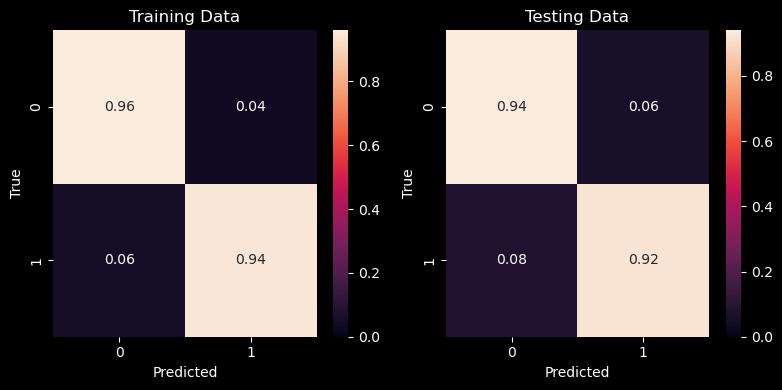

KNeighborsClassifier(n_neighbors=50)


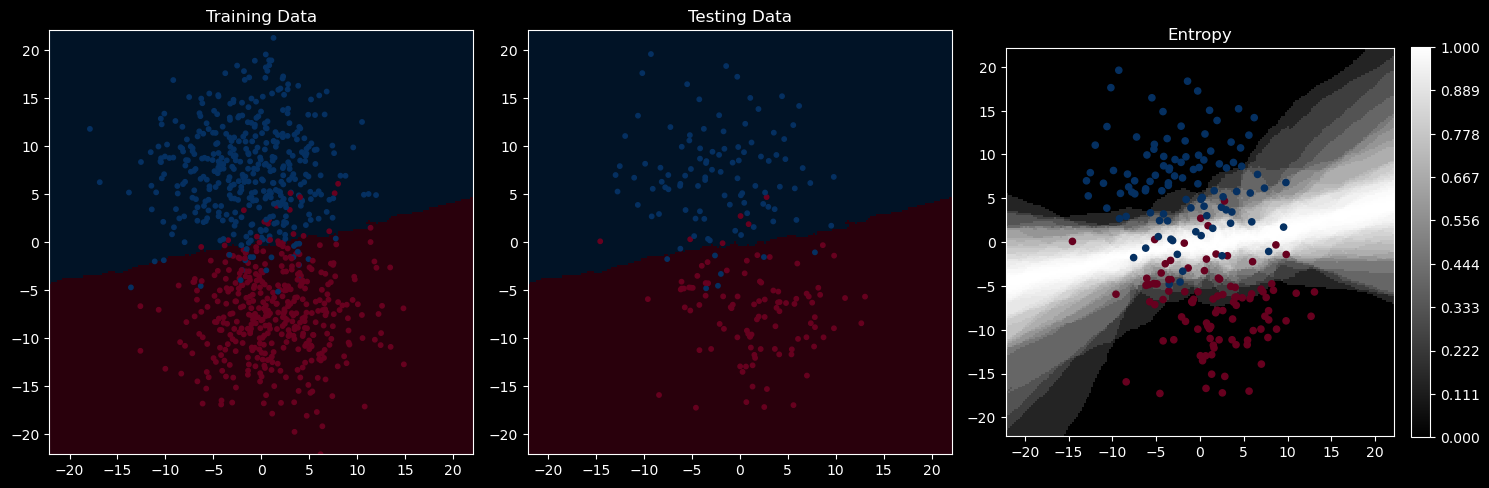

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       100
           1       0.94      0.93      0.93       100

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.93       200
weighted avg       0.94      0.94      0.93       200



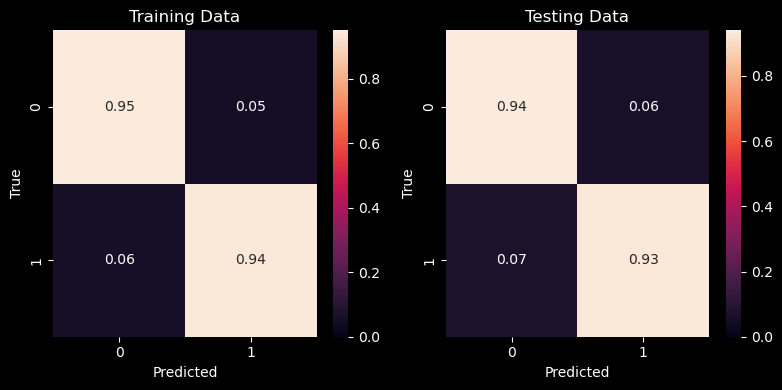

RandomForestClassifier(max_leaf_nodes=10, n_estimators=10)


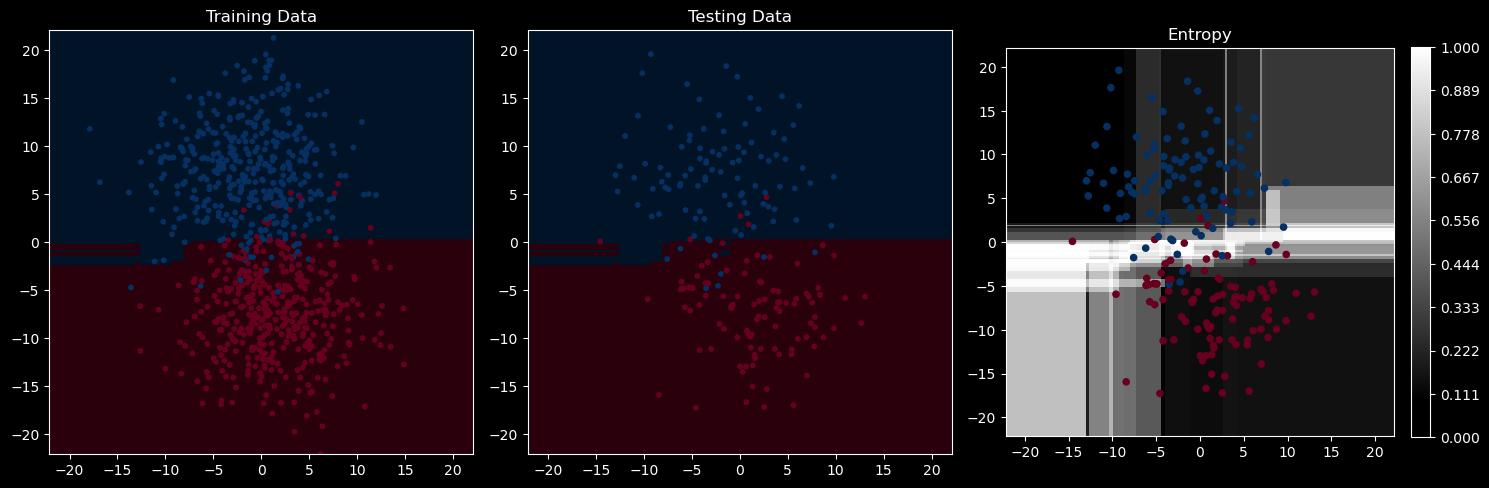

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       100
           1       0.94      0.91      0.92       100

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.92       200
weighted avg       0.93      0.93      0.92       200



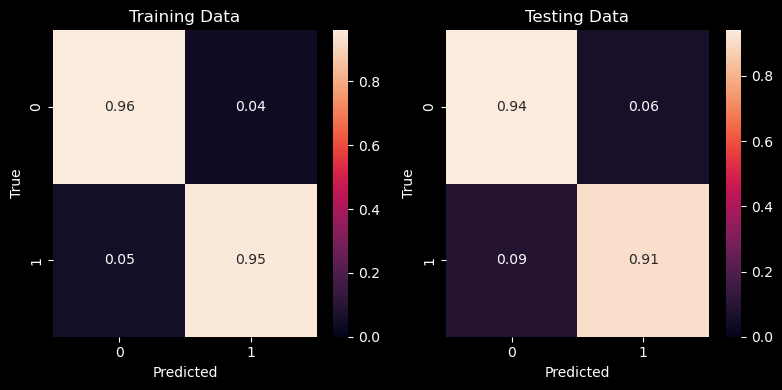

RandomForestClassifier(max_leaf_nodes=3)


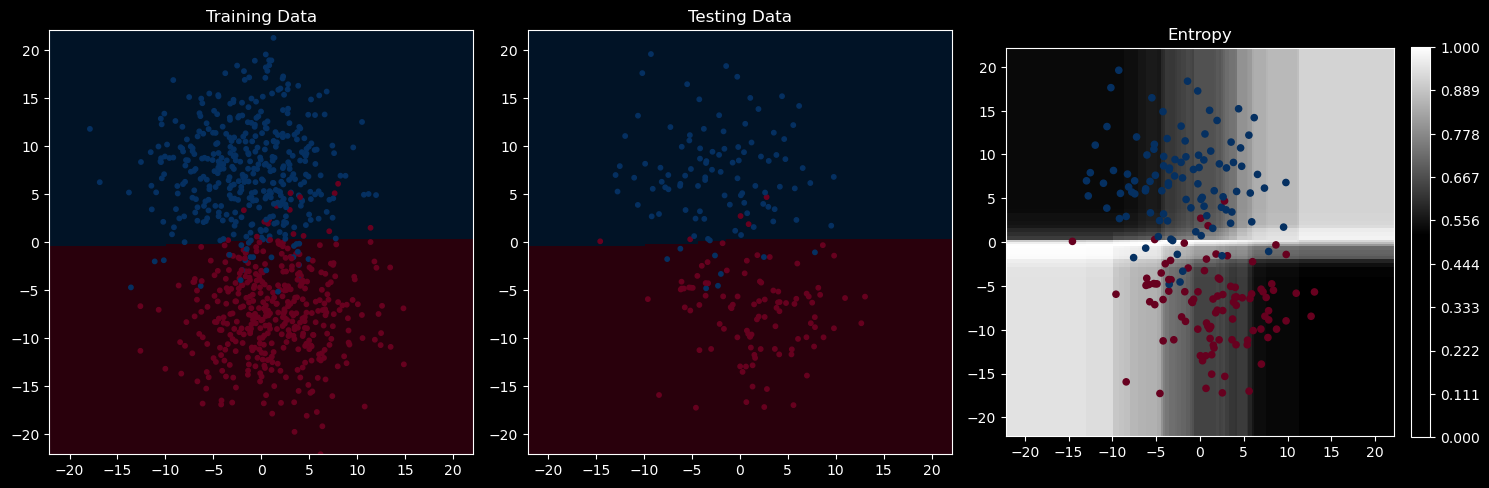

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       100
           1       0.95      0.92      0.93       100

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.93       200
weighted avg       0.94      0.94      0.93       200



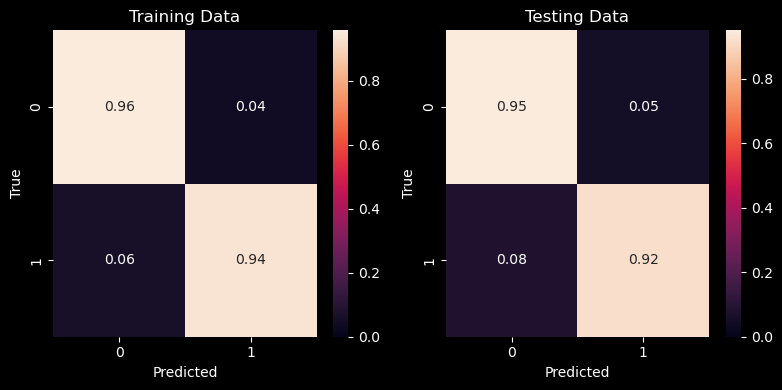

RandomForestClassifier(max_leaf_nodes=10)


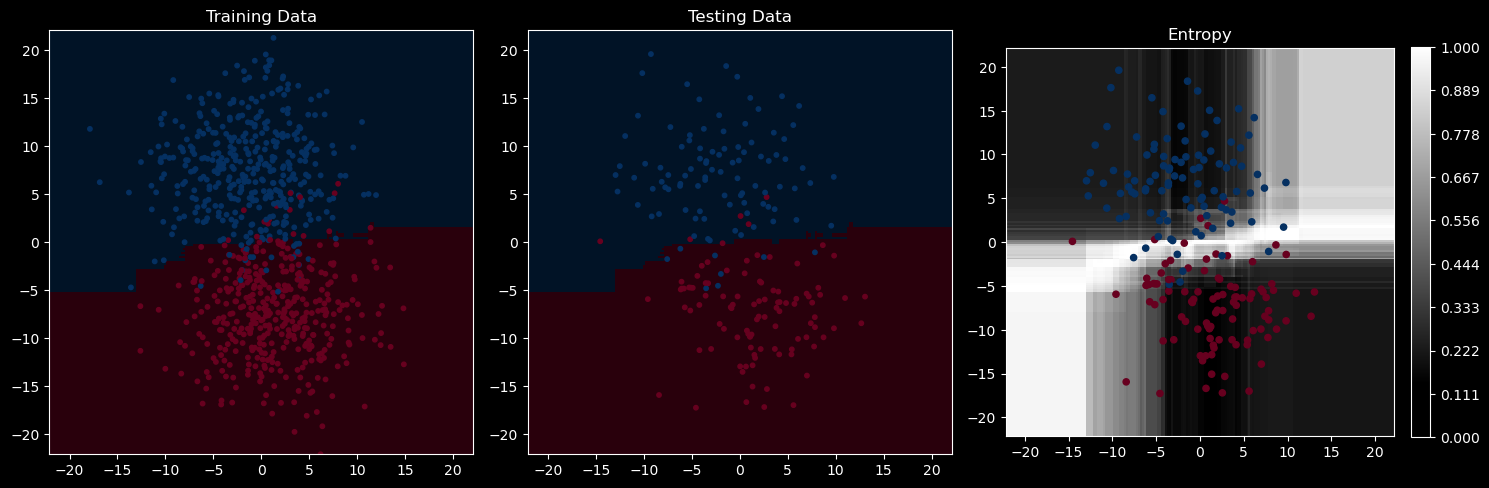

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       100
           1       0.94      0.92      0.93       100

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200



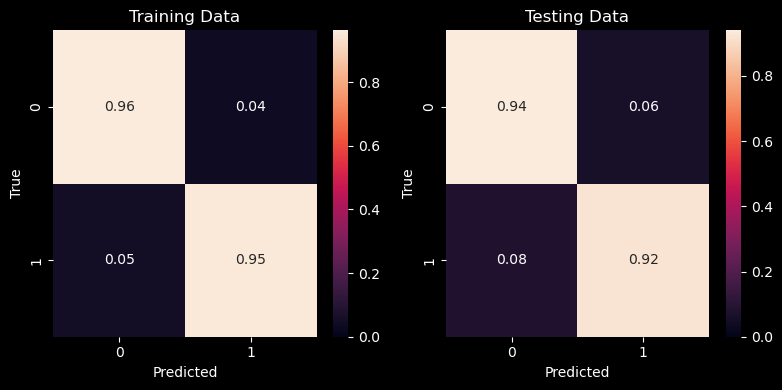

GradientBoostingClassifier(max_leaf_nodes=3, n_estimators=10)


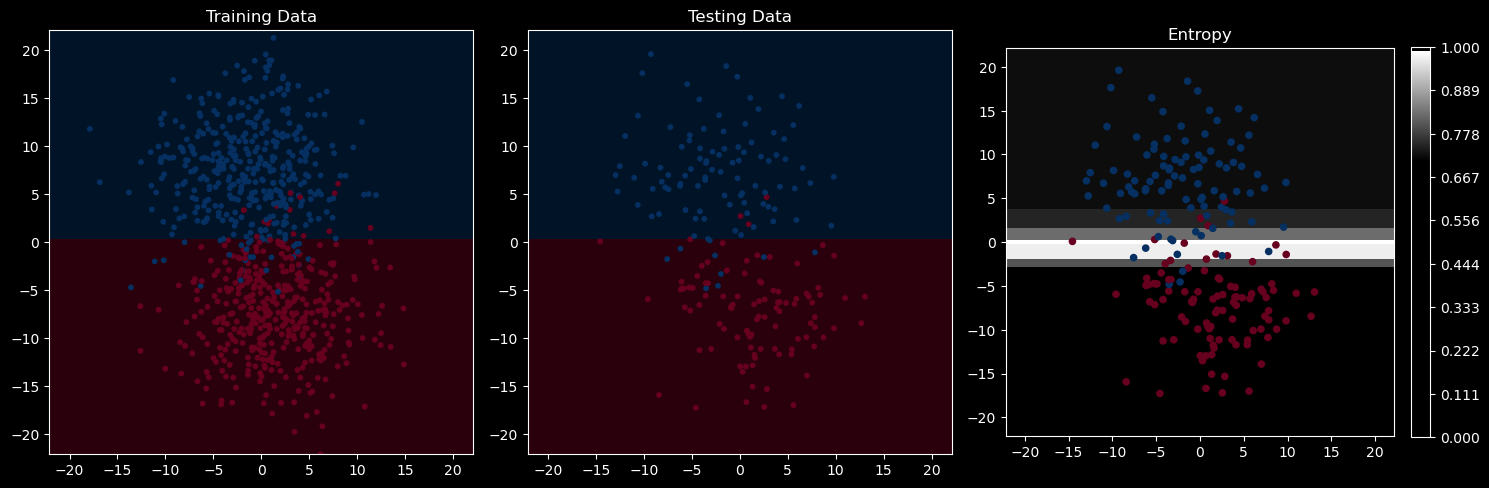

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       100
           1       0.96      0.92      0.94       100

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.94       200



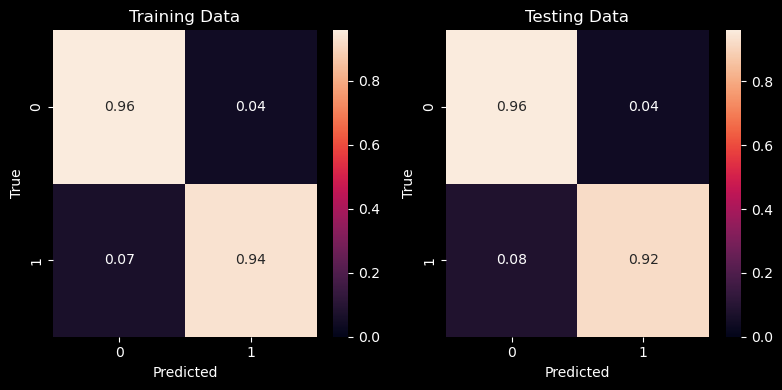

GradientBoostingClassifier(max_leaf_nodes=10, n_estimators=10)


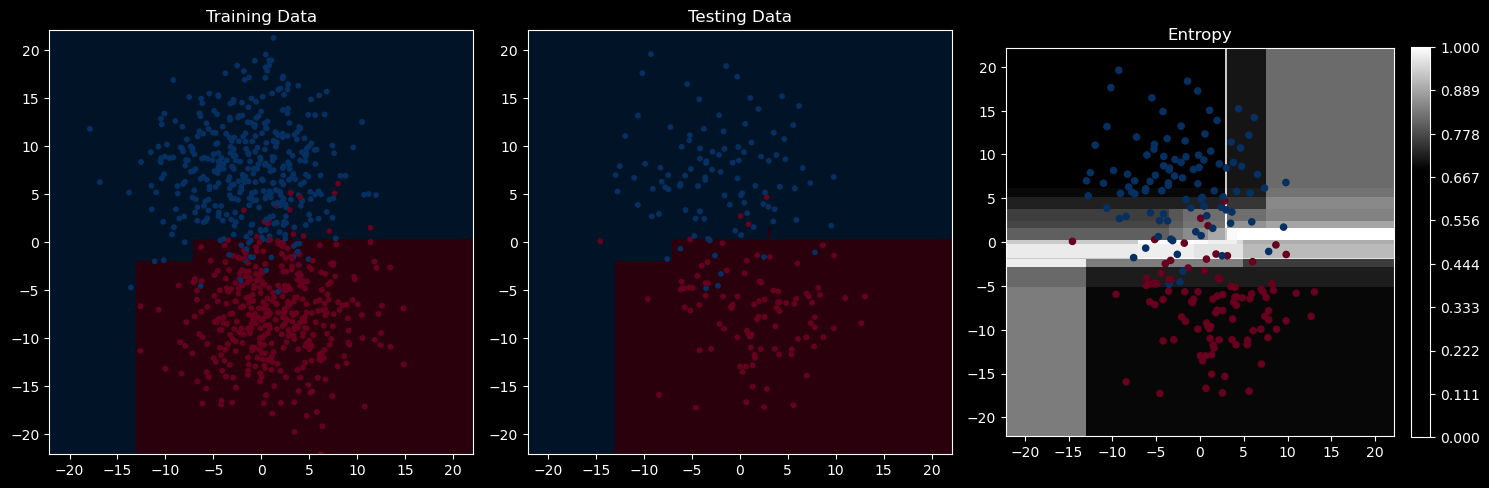

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       100
           1       0.95      0.93      0.94       100

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.94       200



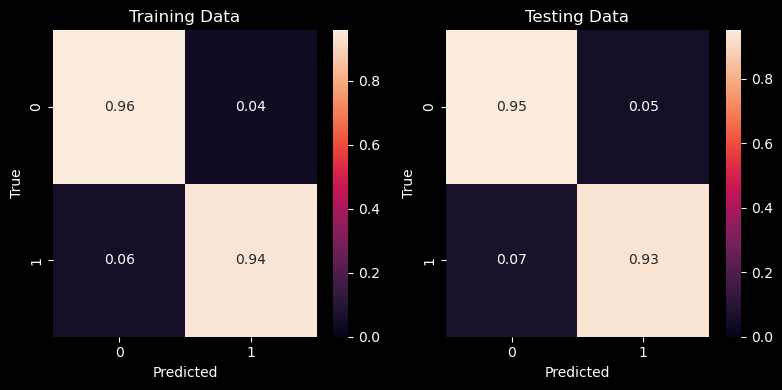

GradientBoostingClassifier(max_leaf_nodes=3)


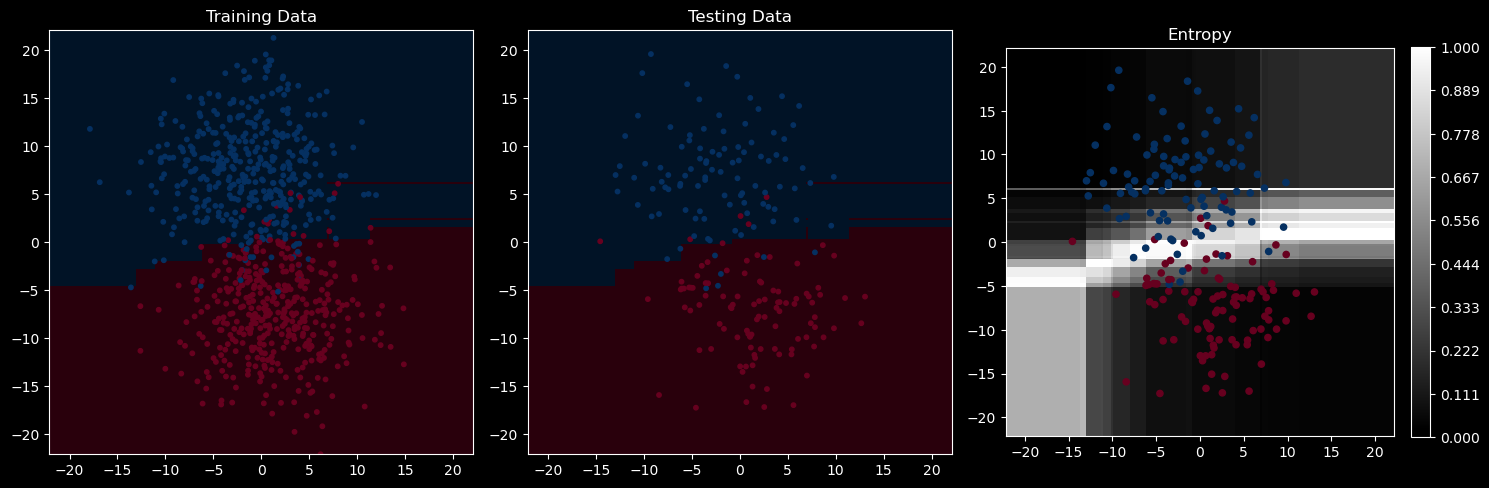

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       100
           1       0.94      0.93      0.93       100

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.93       200
weighted avg       0.94      0.94      0.93       200



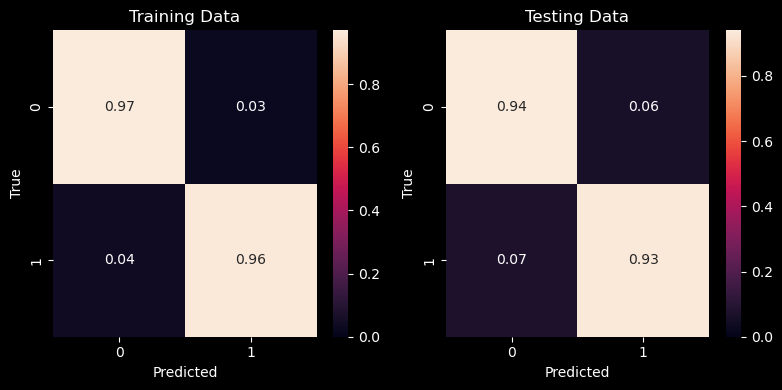

GradientBoostingClassifier(max_leaf_nodes=10)


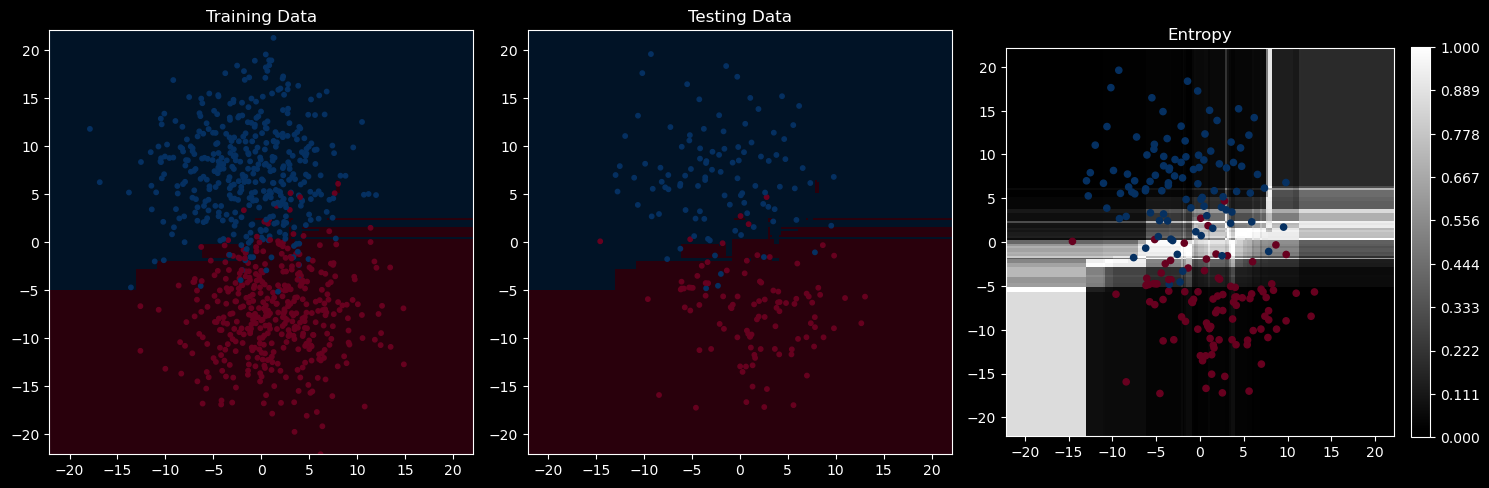

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       100
           1       0.93      0.93      0.93       100

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200



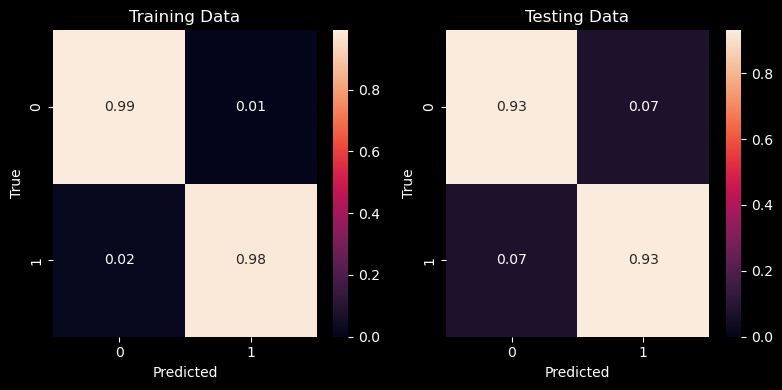

In [21]:
for m in models:
    # Train the model
    m.fit(X_train, y_train)
    
    print(m)

    # Visualize decision regions
    B, S = visualize_regions(m, MAX, 200)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    extent = [-MAX, MAX, -MAX, MAX]
    cmap = "RdBu"

    # Training data decision boundary
    axes[0].imshow(B, interpolation='none', extent=extent, cmap=cmap, alpha=0.4)
    axes[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=cmap)
    axes[0].set_aspect('equal')
    axes[0].set_title('Training Data')

    # Testing data decision boundary
    axes[1].imshow(B, interpolation='none', extent=extent, cmap=cmap, alpha=0.4)
    axes[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=10, cmap=cmap)
    axes[1].set_aspect('equal')
    axes[1].set_title('Testing Data')

    # Entropy visualization
    im = axes[2].imshow(S, interpolation='none', extent=extent, cmap='gray')
    axes[2].scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=20, cmap=cmap)
    axes[2].set_aspect('equal')
    axes[2].set_title('Entropy')
    cbar = fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    cbar.set_ticks(np.linspace(0, math.log(y.max() + 1, 2), 10))

    plt.tight_layout()
    plt.show()

    # Generate predictions
    y_train_pred = m.predict(X_train).astype(int)
    y_test_pred = m.predict(X_test).astype(int)

    # Print classification report
    print(classification_report(y_test, y_test_pred))

    # Compute confusion matrices
    conf_matrix_train = confusion_matrix(y_train, y_train_pred).astype(float)
    conf_matrix_test = confusion_matrix(y_test, y_test_pred).astype(float)

    # Normalize confusion matrices
    for i in range(conf_matrix_train.shape[0]):
        conf_matrix_train[i, :] /= conf_matrix_train[i, :].sum()
        conf_matrix_test[i, :] /= conf_matrix_test[i, :].sum()

    # Create subplots for confusion matrices
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

    # Plot confusion matrix for training data
    sns.heatmap(conf_matrix_train, annot=True, vmin=0, fmt='.2f', ax=axes[0])
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")
    axes[0].set_title("Training Data")

    # Plot confusion matrix for test data
    sns.heatmap(conf_matrix_test, annot=True, vmin=0, fmt='.2f', ax=axes[1])
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("True")
    axes[1].set_title("Testing Data")

    # Show the plots
    plt.tight_layout()
    plt.show()
# end